# Case Final
## Análise de Transações PIX
CRISP-DM - https://www.escoladnc.com.br/blog/data-science/metodologia-crisp-dm/
### Objetivos
- Limpar e pré-processar os dados das transações PIX
- Analisar padrões de uso do PIX, tais como os canais mais utilizados e os valores de transação mais comuns
- Use o PySpark MLlib para treinar e avaliar um modelo de detecção de fraude
- Avaliar o desempenho do modelo e fazer recomendações para melhorias futuras

### Dados

O conjunto de dados inclui as seguintes informações para cada transação:
- Detalhes da transação: valor, tempo, remetente e receptor CPF/CNPJ, tipo
- Etiqueta de fraude: uma variável binária que indica se a transação foi fraudulenta (1) ou não (0)

### Tarefas
- Normalização dos dados:
  - O dataset que você lerá está em formato json.
  ```json
  {
      "id_transacao": inteiro,
      "valor": texto,
      "remetente": {
          "nome": texto,
          "banco": texto,
          "tipo": texto
      },
      "destinatario": {
          "nome": texto,
          "banco":texto,
          "tipo": texto
      },          
      "categoria":texto,
      "chave_pix":texto,
      "transaction_date":texto,
      "fraude":inteiro,
  }
    ```
  - Faça sua transformação para formato colunar
- Análise Exploratória de Dados: Use o PySpark para analisar padrões de uso do PIX:
  - chaves pix mais usadas;
  - os valores de transação mais comuns;
  - distribuição dos valores de transação por hora e dia;
  - quais bancos receberam mais transferências por dia;
  - para qual tipo de pessoa (PF ou PJ) foram realizadas mais transações
- Engenharia de Recursos: Apresentar novas características que podem ser úteis para a detecção de fraudes, tais como o número de transações feitas pelo mesmo remetente em um período de tempo específico.
- Modelagem: Use o PySpark MLlib para treinar e detectar possíveis transações que contenham fraude.

### Observação
É importante notar que este é um caso simplificado, e em cenários do mundo real você teria que lidar com dados mais complexos, usar técnicas mais avançadas como métodos de conjuntos e considerar o conhecimento de domínio, bem como leis e regulamentos das instituições financeiras no Brasil.


### Observação II
Não existe resposta 100% correta. É necessário que você use seu pensamento crítico para definir as melhores métricas e análises para o caso.

# Entendimento do Negócio
Você trabalha em um banco e o principal meio de pagamento utilizado no seu banco é o Pix.

Através da base de transações do pix o banco deseja entender qual é o perfil dos clientes que utilizam o pix, além de verificar possíveis transações que tenham fraude. Porém, eles tem um cliente específico que tem um relacionamento muito bom para o banco, por isso, você recebeu a base de transações de cliente dos últimos 2 anos e precisa a partir dela criar um relatório contendo as principais características das transações.


Então, resumindo, temos dois principais objetivos para esse case:
1. Obter valor a partir dos dados
  - Para qual banco esse cliente mais transfere?
  - Qual é a média de transferências por período que esse cliente faz?
  - Baseando-se no valor das transferências, poderia dar um aumento de crédito?
  - Para o que esse cliente mais usa as transferências?
2. Executar um algoritmo de machine learning que identifique possíveis transações com fraude.
3. Pós Processamento
  - Defina ao mínimo cinco métricas de qualidade para seus dados
  - Explique se os seus dados estão com uma boa qualidade

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Instalar a última versão do PySpark
#!pip install pyspark #==3.3.1


In [10]:
# Instalar o NGROK
!wget -qnc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -n -q ngrok-stable-linux-amd64.zip

# Autenticar a sessão do SparkUI com NGROK
!./ngrok authtoken 2hVBSfnK82L7U9lYAYuchsdHOGC_B6XLEw4aWbRSAFQESEeE
get_ipython().system_raw('./ngrok http 4050 &')
!sleep 10
!curl -s http://localhost:4040/api/tunnels | grep -Po 'public_url":"(?=https)\K[^"]*'

Authtoken saved to configuration file: /home/lundy/.ngrok2/ngrok.yml
Your ngrok-agent version "2.3.41" is too old. The minimum supported agent version for your account is "3.2.0". Please update to a newer version with `ngrok update`, by downloading from https://ngrok.com/download, or by updating your SDK version. Paid accounts are currently excluded from minimum agent version requirements. To begin handling traffic immediately without updating your agent, upgrade to a paid plan: https://dashboard.ngrok.com/billing/subscription.

ERR_NGROK_121



24/06/15 10:39:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Undesrtanting

Primeiramente, devemos entender tudo sobre a fonte dos dados
- Como o dado chega até nós?
- Qual formato virá?
- Aonde o processamento será executado (AWS EMR, Cluster On-Premise)?
- De quanto em quanto tempo eu preciso gerar esse relatório (mensal, diário, near-real time)?

```json
{
  "id_transacao": inteiro,
  "valor": texto,
  "remetente": {
      "nome": texto,
      "banco": texto,
      "tipo": texto
  },
  "destinatario": {
      "nome": texto,
      "banco":texto,
      "tipo": texto
  },
  "categoria": texto,
  "transaction_date":texto,
  "chave_pix":texto,
  "fraude":inteiro,
}
```



# Preparação dos Dados
Agora é hora de começar a preparar os dados de acordo com as suas necessidades.

In [12]:
# Iniciar a sessão spark
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
      .config('spark.ui.port', '4050')
      .appName("CaseFinal")
      .getOrCreate()
)

In [13]:
from pyspark.sql.types import *

#caminho_json = 'drive/MyDrive/lake/case_final.json'
caminho_json = 'case_final.json'

schemma_remetente_destinatario = StructType([
    StructField('nome', StringType()),
    StructField('banco', StringType()),
    StructField('tipo', StringType()),
])

schema_base_pix = StructType([
    StructField('id_transacao', IntegerType()),
    StructField('valor', DoubleType()),
    StructField('remetente', schemma_remetente_destinatario),
    StructField('destinatario', schemma_remetente_destinatario),
    StructField('categoria', StringType()),
    StructField('chave_pix', StringType()),
    StructField('transaction_date', StringType()),
    StructField('fraude', IntegerType()),
])

# 2022-10-20 10:57:36

df = spark.read.json(
    caminho_json,
    schema=schema_base_pix,
    timestampFormat="yyyy-MM-dd HH:mm:ss",
)

In [14]:
df.printSchema()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- remetente: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- destinatario: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- fraude: integer (nullable = true)



In [15]:
df.show()

+------------+------------------+--------------------+--------------------+-------------+---------+-------------------+------+
|id_transacao|             valor|           remetente|        destinatario|    categoria|chave_pix|   transaction_date|fraude|
+------------+------------------+--------------------+--------------------+-------------+---------+-------------------+------+
|        1000|            588.08|{Jonathan Gonsalv...|{Calebe Melo, Cai...|       outros|aleatoria|2021-07-16 05:00:55|     0|
|        1001|           80682.5|{Jonathan Gonsalv...|{Davi Lucas Perei...|transferencia|  celular|2022-04-20 12:34:01|     1|
|        1002|             549.9|{Jonathan Gonsalv...|{Sabrina Castro, ...|        lazer|      cpf|2022-07-10 16:51:34|     0|
|        1003|             90.83|{Jonathan Gonsalv...|{Francisco da Con...|   transporte|aleatoria|2022-10-20 10:57:36|     0|
|        1004|13272.619999999999|{Jonathan Gonsalv...|{Isabelly Ferreir...|transferencia|    email|2021-04-06 2

In [16]:
from pyspark.sql.functions import col

df_flatten = df.withColumns({
    'remetente_nome': col('remetente').getField('nome'),
    'remetente_banco': col('remetente').getField('banco'),
    'remetente_tipo': col('remetente').getField('tipo'),
    'destinatario_nome':col('destinatario').getField('nome'),
    'destinatario_banco':col('destinatario').getField('banco'),
    'destinatario_tipo':col('destinatario').getField('tipo'),
    }).drop('remetente', 'destinatario')


In [17]:
df_flatten.printSchema()
df_flatten.show()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)



+------------+------------------+-------------+---------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+
|id_transacao|             valor|    categoria|chave_pix|   transaction_date|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|
+------------+------------------+-------------+---------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+
|        1000|            588.08|       outros|aleatoria|2021-07-16 05:00:55|     0|Jonathan Gonsalves|            BTG|            PF|         Calebe Melo|             Caixa|               PF|
|        1001|           80682.5|transferencia|  celular|2022-04-20 12:34:01|     1|Jonathan Gonsalves|            BTG|            PF|  Davi Lucas Pereira|             Caixa|               PJ|
|        1002|             549.9|  

In [18]:
df_flatten.describe().show()

24/06/15 10:39:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+-----------+---------+-------------------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|summary|     id_transacao|             valor|  categoria|chave_pix|   transaction_date|            fraude|    remetente_nome|remetente_banco|remetente_tipo|destinatario_nome|destinatario_banco|destinatario_tipo|
+-------+-----------------+------------------+-----------+---------+-------------------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|     100000|   100000|             100000|            100000|            100000|         100000|        100000|           100000|            100000|           100000|
|   mean|          50999.5|10303.358732200059|       NULL|     NULL|               NULL|           0.15367|              NULL|           NULL|      

# Modelagem
Aqui você encontrará utilidade para os dados levantados.

Aqui será onde teremos insights e, a partir desses, novos conhecimentos sobre o business (se tudo até aqui foi feito corretamente).


- Para qual banco esse cliente mais transfere?
- Qual é a média de transferências por período que esse cliente faz?
- Baseando-se no valor das transferências, poderia dar um aumento de crédito?
- Para o que esse cliente mais usa as transferências?
- Executar um algoritmo de machine learning que identifique possíveis transações com fraude.


In [19]:
from pyspark.sql.functions import date_format

df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy-MM').alias('ano_mes'),
    'destinatario_banco'
    ).count().orderBy(col('ano_mes').desc()).show()

+-------+------------------+-----+
|ano_mes|destinatario_banco|count|
+-------+------------------+-----+
|2023-01|              Itau|  267|
|2023-01|             Caixa|  277|
|2023-01|                XP|  277|
|2023-01|          Bradesco|  280|
|2023-01|            Nubank|  290|
|2023-01|                C6|  290|
|2023-01|               BTG|  278|
|2022-12|                XP|  615|
|2022-12|               BTG|  603|
|2022-12|                C6|  576|
|2022-12|          Bradesco|  575|
|2022-12|            Nubank|  602|
|2022-12|              Itau|  633|
|2022-12|             Caixa|  616|
|2022-11|          Bradesco|  579|
|2022-11|               BTG|  580|
|2022-11|              Itau|  614|
|2022-11|            Nubank|  620|
|2022-11|             Caixa|  543|
|2022-11|                C6|  561|
+-------+------------------+-----+
only showing top 20 rows



In [20]:
df_media_banco = df_flatten.groupBy('destinatario_banco').avg('valor').orderBy('avg(valor)')

df_media_banco.show()


+------------------+------------------+
|destinatario_banco|        avg(valor)|
+------------------+------------------+
|               BTG|10122.299803335622|
|              Itau|10230.876305580874|
|             Caixa|10254.864015449395|
|                C6|10309.499774711307|
|            Nubank|10316.475401133126|
|                XP|10328.071572113045|
|          Bradesco| 10564.19458870794|
+------------------+------------------+



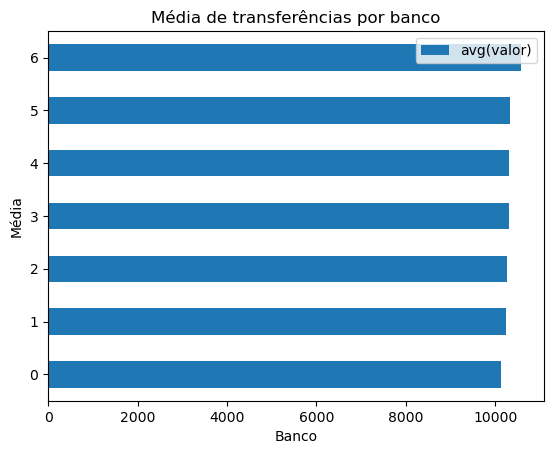

In [21]:
df_media_banco.toPandas().plot(kind='barh')
plt.xlabel('Banco')
plt.ylabel('Média')
plt.title('Média de transferências por banco')
plt.show()

In [22]:
#Qual é a média de transferências por período que esse cliente faz?

df_flatten.groupBy(
    date_format('transaction_date', 'yyyy').alias('ano')
).mean('id_transacao').orderBy('ano').show()

+----+------------------+
| ano| avg(id_transacao)|
+----+------------------+
|2021| 51204.03597092333|
|2022|50823.494263441935|
|2023| 50481.67993874426|
+----+------------------+



In [23]:
#Baseando-se no valor das transferências, poderia dar um aumento de crédito?
#A fazer

In [24]:
#Para o que esse cliente mais usa as transferências?

from pyspark.sql.functions import date_format

df_group_categoria = df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy-MM').alias('ano_mes'),
    'destinatario_banco',
    'categoria'
).count().orderBy('ano_mes')

df_group_categoria.show()

+-------+------------------+-------------+-----+
|ano_mes|destinatario_banco|    categoria|count|
+-------+------------------+-------------+-----+
|2021-01|             Caixa|     educacao|   24|
|2021-01|              Itau|        saude|   40|
|2021-01|            Nubank|        saude|   28|
|2021-01|                XP|    presentes|   38|
|2021-01|               BTG|   transporte|   29|
|2021-01|               BTG|  alimentacao|   31|
|2021-01|              Itau|transferencia|   75|
|2021-01|                XP|       outros|   34|
|2021-01|                XP|   transporte|   26|
|2021-01|          Bradesco|transferencia|   96|
|2021-01|              Itau|    vestuario|   28|
|2021-01|               BTG|        lazer|   34|
|2021-01|          Bradesco|   transporte|   40|
|2021-01|                XP|transferencia|   89|
|2021-01|                C6|  alimentacao|   38|
|2021-01|             Caixa|        lazer|   37|
|2021-01|          Bradesco|       outros|   25|
|2021-01|           

In [25]:
df_flatten.groupBy(
    date_format(col('transaction_date'), 'yyyy').alias('ano'),
    'categoria'
).sum('valor').select('ano', 'categoria', col('sum(valor)').cast(DecimalType(38, 3)).alias('valor')).orderBy('valor').show(30)

+----+-------------+-------------+
| ano|    categoria|        valor|
+----+-------------+-------------+
|2023|    presentes|   362584.450|
|2023|  alimentacao|   392078.310|
|2023|        saude|   400683.640|
|2023|   transporte|   427790.540|
|2023|     educacao|   432305.660|
|2023|    vestuario|   459528.700|
|2023|        lazer|   469671.410|
|2023|       outros|   501308.340|
|2021|   transporte|  9497893.470|
|2021|        lazer|  9622503.140|
|2021|       outros|  9737076.380|
|2022|        saude| 10048245.070|
|2021|     educacao| 10106095.070|
|2021|  alimentacao| 10237928.250|
|2022|        lazer| 10295747.630|
|2022|    presentes| 10311585.740|
|2022|     educacao| 10367124.440|
|2021|        saude| 10384662.820|
|2021|    vestuario| 10412651.930|
|2021|    presentes| 10496042.020|
|2022|  alimentacao| 10545783.230|
|2022|   transporte| 10553408.290|
|2022|       outros| 10566645.100|
|2022|    vestuario| 10696006.480|
|2023|transferencia| 16148682.620|
|2021|transferencia|

In [26]:
#entendendo a qtd de fraudes
df_flatten.groupby('fraude').count().show()

+------+-----+
|fraude|count|
+------+-----+
|     1|15367|
|     0|84633|
+------+-----+



In [27]:
#entendendo a qtd de fraudes por categoria
df_flatten.groupby('categoria', 'fraude').count().show()

+-------------+------+-----+
|    categoria|fraude|count|
+-------------+------+-----+
|       outros|     0| 9377|
|     educacao|     0| 9460|
|transferencia|     0| 9377|
|transferencia|     1|15367|
|    presentes|     0| 9254|
|        saude|     0| 9476|
|        lazer|     0| 9464|
|   transporte|     0| 9174|
|    vestuario|     0| 9503|
|  alimentacao|     0| 9548|
+-------------+------+-----+



In [51]:
#filtrando a categoria transferencia
df_flatten.filter(
    col('categoria') == 'transferencia'
  ).groupby(
      'categoria', 'fraude'
      ).count().show()

+-------------+------+-----+
|    categoria|fraude|count|
+-------------+------+-----+
|transferencia|     0| 9377|
|transferencia|     1|15367|
+-------------+------+-----+



In [29]:
from pyspark.sql.functions import floor

df_flatten.filter(col('fraude') == '1').withColumn(
    "range",
    floor(col('valor')/1000)*1000
).groupBy('range').count().orderBy(col('range').desc()).show()

+-----+-----+
|range|count|
+-----+-----+
|89000|  222|
|88000|  208|
|87000|  230|
|86000|  203|
|85000|  205|
|84000|  245|
|83000|  206|
|82000|  206|
|81000|  214|
|80000|  213|
|79000|  205|
|78000|  230|
|77000|  237|
|76000|  232|
|75000|  190|
|74000|  207|
|73000|  237|
|72000|  234|
|71000|  234|
|70000|  222|
+-----+-----+
only showing top 20 rows



In [30]:
#entendendo o range de valores que houve fraude
from pyspark.sql.functions import floor, max, min

df_flatten.filter(
    col('fraude') == '1'
).withColumn(
    "range", floor(col('valor')/1000)*1000
).select(min('range'), max('range')).show()

+----------+----------+
|min(range)|max(range)|
+----------+----------+
|     19000|     89000|
+----------+----------+



#Modelo de Predição de Fraudes

In [31]:
#Pipeline serve para ordenar o que sera executado, mostrando que primeiro executa X tarefa depois Y.
from pyspark.sql.functions import col, udf

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [32]:
df = df_flatten.drop('remetente', 'id')

In [33]:
indexer = StringIndexer(
    inputCols=[
        "destinatario_nome",
        "destinatario_banco",
        "destinatario_tipo",
        "categoria",
        "chave_pix"
    ],
    outputCols=[
          "destinatario_nome_index",
          "destinatario_banco_index",
          "destinatario_tipo_index",
          "categoria_index",
          "chave_pix_index"
  ])


In [34]:
df_index = indexer.fit(df).transform(df)
df_index.show()

24/06/15 10:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1278.8 KiB


+------------+------------------+-------------+---------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|id_transacao|             valor|    categoria|chave_pix|   transaction_date|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|destinatario_nome_index|destinatario_banco_index|destinatario_tipo_index|categoria_index|chave_pix_index|
+------------+------------------+-------------+---------+-------------------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|        1000|            588.08|       outros|aleatoria|2021-07-16 05:00:55|     0|Jonathan Gonsalves|   

In [35]:
cols_para_filtrar = [
    'valor',
    'transaction_date',
    'destinatario_nome_index',
    'destinatario_banco_index',
    'destinatario_tipo_index',
    'chave_pix_index',
    'categoria_index',
    'fraude'
]

In [36]:
is_fraud = df_index.select(cols_para_filtrar).filter(col('fraude') == '1')
no_fraud = df_index.select(cols_para_filtrar).filter(col('fraude') == '0')

no_fraud = no_fraud.sample(False, 0.01, seed=123)


In [37]:
df_concat = no_fraud.union(is_fraud)
df = df_concat.sort("transaction_date")
df.count()

16202

In [38]:
train, test = df.randomSplit([0.7, 0.3], seed=123)
print(f"Train: {train.count()} | Test: {test.count()}")

24/06/15 10:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/15 10:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1296.7 KiB
24/06/15 10:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB


Train: 11278 | Test: 4924


24/06/15 10:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1296.7 KiB


In [39]:
is_fraud = udf(lambda fraud: 1.0 if fraud > 0 else 0.0, DoubleType())
train = train.withColumn("is_fraud", is_fraud(train.fraude))

In [40]:
# Create the feature vectors.
# VectorAssembler is a transformer that combines a given list of columns into a single vector column.
assembler = VectorAssembler(
    inputCols = [x for x in train.columns if x not in ['transaction_date', 'fraude', 'is_fraud']],
    outputCol='features')

# Use Logistic Regression.
# is a machine learning algorithm that is used for classification tasks
lr = LogisticRegression().setParams(
    maxIter=100000,
    labelCol="is_fraud",
    predictionCol="prediction")

# This will train a logistic regression model on the input data and return a
# LogisticRegressionModel object which can be used to make predictions on new data.
model = Pipeline(stages = [assembler, lr]).fit(train)

24/06/15 10:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/15 10:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/15 10:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1340.8 KiB
24/06/15 10:40:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/15 10:40:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/15 10:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1341.5 KiB
24/06/15 10:40:01 WARN DAGScheduler: Broadcasting large task binary wit

In [41]:
predicted = model.transform(test)
predicted = predicted.withColumn("is_fraud", is_fraud(predicted.fraude))
predicted.crosstab("is_fraud", "prediction").show()

24/06/15 10:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/15 10:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1339.7 KiB
24/06/15 10:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
24/06/15 10:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
24/06/15 10:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
24/06/15 10:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/15 10:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
24/06/15 10:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/15 10:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1346.6 KiB
24/06/15 10:40:18 WAR

+-------------------+---+----+
|is_fraud_prediction|0.0| 1.0|
+-------------------+---+----+
|                1.0|  0|4660|
|                0.0|262|   2|
+-------------------+---+----+



24/06/15 10:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1338.0 KiB


# Avaliação do Modelo
Será que seu modelo atinge todas as necessidades que foram definidas inicialmente? (e.g. pessoa em cima da bicicleta muda o resultado final)



# Deployment
Apresente o relatório com os resultados obtidos.

Foi constatado que o cliente Jonathan Gonsalve realiza um número elevado de transferências Pix mensais. A partir das análises feitas, observou-se que a principal categoria de transação é a transferência bancária.

Além disso, notou-se que o segundo banco mais utilizado pelo cliente é o BTG, embora o valor total das transações para esse banco seja o menor. Isso sugere que Jonathan realiza várias transferências de pequeno valor para o BTG.

Outro ponto importante é o alto índice de tentativas de fraude na conta desse cliente. Todas essas tentativas envolveram valores superiores a R$19.999,00 e se enquadram na categoria de transferências. Em resposta a isso, foi desenvolvido um algoritmo de machine learning capaz de identificar esse tipo de transação fraudulenta.

Conclui-se, portanto, que há um significativo número de tentativas de fraudes nas transações. Uma ação recomendada seria reduzir o limite máximo para as transferências Pix desse cliente. É provável que Jonathan esteja utilizando esta conta pessoal (PF) para finalidades empresariais (PJ), dado o elevado volume e os altos valores das transferências.